In [1]:
import numpy as np
import keras.backend as K
import tensorflow as tf

import Diffusion as df
import os.path
from autoencoder import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.utils import np_utils
from keras.layers import Dense, Input
from keras.models import Model
from keras import regularizers

Using TensorFlow backend.


##  Generate data #######################

The dataset is 2000 random samples from a closed curve in 3D: 

$x_i = \left( \cos(\theta_i), \sin(2\theta_i) , \sin(3\theta_i)\right)^T, \;\;\; \theta_i \in (0,2\pi).    $

In [2]:
n = 3000
t = 2.01*np.pi*np.random.uniform(0,1,n)
x = np.cos(t)
y = np.sin(2*t)
z = np.sin(3*t)
orig_data = np.vstack([x,y,z])
orig_data = np.transpose(orig_data)

# add noise
noise_std = 0.05
data = orig_data + noise_std*np.random.randn(orig_data.shape[0],orig_data.shape[1])

n_train = 2000
n_test = n - n_train

S1_train   = data[:n_train,:]
S1_test    = data[n_train+1:,:]
t_train    = t[:n_train]
t_test     = t[n_train+1:]
input_size = S1_train.shape[1]
batch_size = S1_train.shape[0]

sort_inds = np.argsort(t_train)

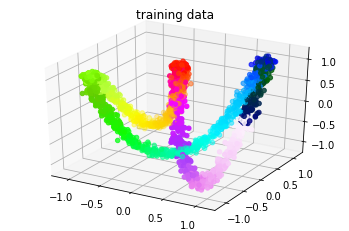

In [3]:
fig, (a1)  = plt.subplots(1,1, subplot_kw={'projection':'3d'})
a1.scatter(S1_train[:,0], S1_train[:,1], S1_train[:,2], c=t_train, cmap='gist_ncar')
plt.title('training data')
plt.show()

The diffusion map of a closed curve is a 2D circle.

In [4]:
embedding_size = 2
k = 16
K_mat = df.ComputeLBAffinity(S1_train,k,sig=0, ref_neighbor=None, kernel=None)   # Laplace-Beltrami affinity: D^-1 * K * D^-1
P     = df.makeRowStoch(K_mat)                     # markov matrix 
E1,v1 = df.Diffusion(K_mat, nEigenVals=embedding_size+1)  # eigenvalues and eigenvectors
S1_embedding = np.matmul(E1, np.diag(v1)) # diffusion maps

Unknown metric, use gaussian instead


/Users/larsmushom/Documents/Jobb/Simula/Project/DiffusionNet/Diffusion.py:36: RuntimeWarning: divide by zero encountered in true_divide
  d = 1. / np.sum(K, axis = 0)


NameError: name 'D_inv' is not defined

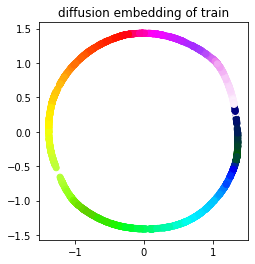

In [10]:
fig, (a1)  = plt.subplots(1,1)
a1.scatter(E1[:,0], E1[:,1], c=t_train, cmap='gist_ncar')
plt.title('diffusion embedding of train')
a1.set_aspect('equal')
plt.show()

# Diffusion Net

We begin with layer-wise pre-training of the encoder and the decoder using sparse auto-encoders. We then train the full encoder and full decoder. 

### config net #######################


In [11]:
N_EPOCHS = 2000

The encoder and decoder networks both have 2 hidden layers, and are constrcuted in revrese of one another.

In [12]:
# number of units in encoder and decoder
encoder_layer_sizes = [40, 20, embedding_size]
decoder_layer_sizes = [20, 40, input_size]


We begin with a layer-wise pre-training of the encoder and the decoder using stacked sparse autoencoders, as in http://ufldl.stanford.edu/wiki/index.php/Autoencoders_and_Sparsity

## Pre-train encoder

Pre-training first hidden layer from the 3D input to 40 hidden units.

In [13]:
autoencoder1 = Autoencoder(input_size=input_size, hidden_size=encoder_layer_sizes[0], 
                            reg_par=1e-10,output_activation='linear',p=0.05,beta=0.01)

autoencoder1.compile(optimizer='adam')
autoencoder1.train(S1_train,batch_size=n_train,n_epochs=N_EPOCHS)
output1 = autoencoder1.predict(S1_train)

encoder1_train = autoencoder1.encode(S1_train)  # this is the output of the first hidden layer

W0625 11:25:46.321348 4626838976 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 11:25:46.560408 4626838976 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 11:25:46.749562 4626838976 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 11:25:46.937632 4626838976 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1521: The name tf.log is deprecated. Please use tf.math.log instead.

W0625 11:25:47.132821 4626838976 deprecation_wrapper.py:119] From /usr/local/lib/python3

Plot pre-trained autoencoder output

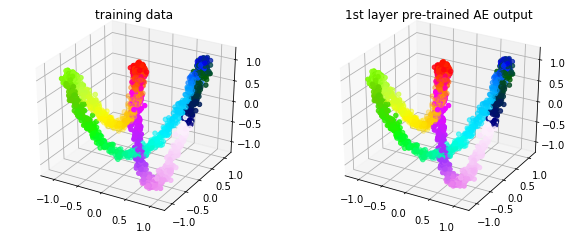

In [14]:
fig = plt.figure(figsize=(10,4))
a1 = fig.add_subplot(121,projection='3d')
a1.scatter(S1_train[:,0], S1_train[:,1], S1_train[:,2], c=t_train, cmap='gist_ncar')
a1.set_title('training data')
a2 = fig.add_subplot(122,projection='3d')
a2.scatter(output1[:,0], output1[:,1], output1[:,2], c=t_train, cmap='gist_ncar')
a2.set_title('1st layer pre-trained AE output')
plt.show()


Activation of the hidden units of the first layer, where the data points have been sorted according to their location across the curve. The hidden units indeed "respond" to only on a subset of the data.

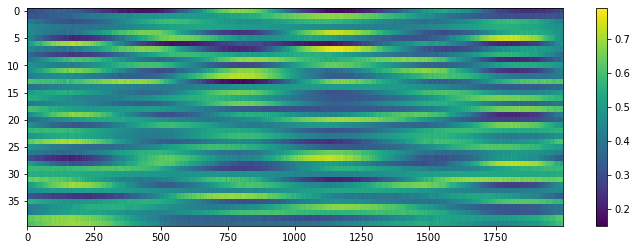

In [15]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plt.imshow(encoder1_train[sort_inds,:].T)
ax.set_aspect('auto')
plt.colorbar()
plt.show()

Pre-training second hidden layer from 40 hidden units to 20 hidden units. The output of the first layer is the input of the second layer to be pre-trained as an autoencoder.

In [16]:
autoencoder2 = Autoencoder(input_size=encoder_layer_sizes[0], hidden_size=encoder_layer_sizes[1], 
                            reg_par=1e-7,p=0.1,beta=0.01)

autoencoder2.compile(optimizer='adam')
autoencoder2.train(encoder1_train,batch_size=n_train,n_epochs=N_EPOCHS)

encoder2_train = autoencoder2.encode(encoder1_train) # this is the output of the second hidden layer

Activation of the hidden units of the second layer, uisng a different visualization. Each 3D curve is colored by the response of the hidden unit.

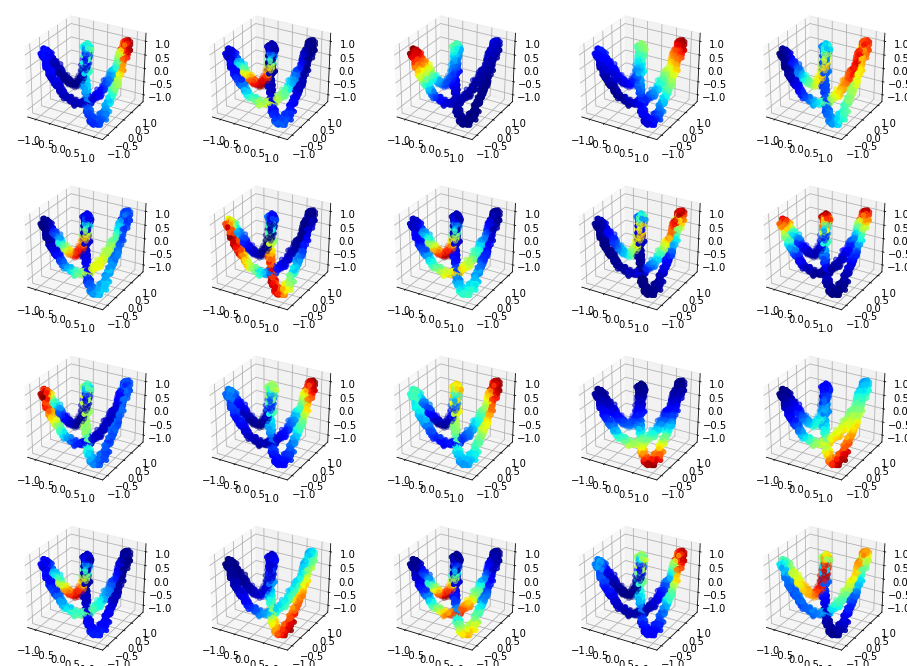

In [17]:
fig = plt.figure(figsize=(16,12))
for i in range(20):
    a1 = fig.add_subplot(4,5,i+1,projection='3d')
    a1.scatter(S1_train[:,0], S1_train[:,1], S1_train[:,2], c=encoder2_train[:,i], cmap='jet')
plt.show()

Pre-train encoder output (regression from 20 hidden units to 2D embedding). 

TODO: add eigenvector cost to regression cost

In [18]:
encoder3 = pretrain_regression(encoder2_train, S1_embedding, encoder_layer_sizes[1], encoder_layer_sizes[2], 
                               batch_size, reg_par=1e-7, n_epochs=N_EPOCHS) 

encoder3_train = encoder3.predict(encoder2_train)

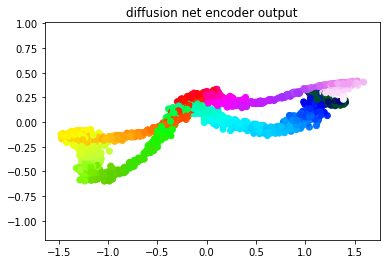

In [19]:
fig, (a2)  = plt.subplots(1,1)
a2.scatter(encoder3_train[:,0], encoder3_train[:,1], c=t_train, cmap='gist_ncar')
plt.axis('equal')
plt.title('diffusion net encoder output')
plt.show()

## Pre-train decoder

Pre-training first hidden layer from the 2D embedding to 20 hidden units.

In [20]:
de_autoencoder1 = Autoencoder(input_size=embedding_size, hidden_size=decoder_layer_sizes[0], 
                            reg_par=1e-4,output_activation='linear',p=0.05,beta=0.01)

de_autoencoder1.compile(optimizer='adam')
de_autoencoder1.train(S1_embedding,batch_size=n_train,n_epochs=N_EPOCHS)
de_output1 = de_autoencoder1.predict(S1_embedding)

de_encoder1_train = de_autoencoder1.encode(S1_embedding)  # this is the output of the first hidden layer

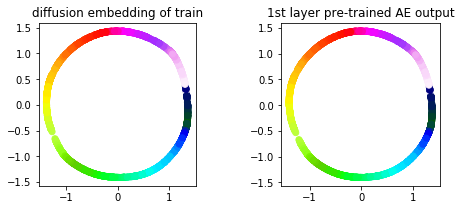

In [21]:
fig = plt.figure(figsize=(8,3))
a1 = fig.add_subplot(121)
a1.scatter(S1_embedding[:,0], S1_embedding[:,1], c=t_train, cmap='gist_ncar')
plt.title('diffusion embedding of train')
a1.set_aspect('equal')
a2 = fig.add_subplot(122)
a2.scatter(de_output1[:,0], de_output1[:,1], c=t_train, cmap='gist_ncar')
a2.set_aspect('equal')
plt.title('1st layer pre-trained AE output')
plt.show()

Activation of the hidden units of the first layer, where the data points have been sorted according to their location across the curve. The hidden units indeed "respond" to only on a subset of the data.

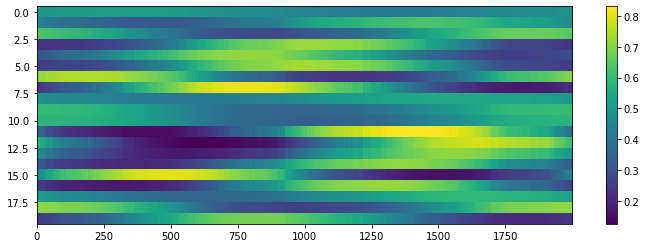

In [22]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)
plt.imshow(de_encoder1_train[sort_inds,:].T)
plt.colorbar()
ax.set_aspect('auto')
plt.show()

Pre-training second hidden layer from 40 hidden units to 20 hidden units. The output of the first layer is the input of the second layer to be pre-trained as an autoencoder.

In [23]:
de_autoencoder2 = Autoencoder(input_size=decoder_layer_sizes[0], hidden_size=decoder_layer_sizes[1], 
                            reg_par=1e-7,p=0.05,beta=0.01)                          

de_autoencoder2.compile(optimizer='adam')
de_autoencoder2.train(de_encoder1_train,batch_size=n_train,n_epochs=N_EPOCHS)
de_encoder2_train = de_autoencoder2.encode(de_encoder1_train)

Activation of the hidden units of the second layer, where the 2D embedding is colored by the response of the hidden unit.

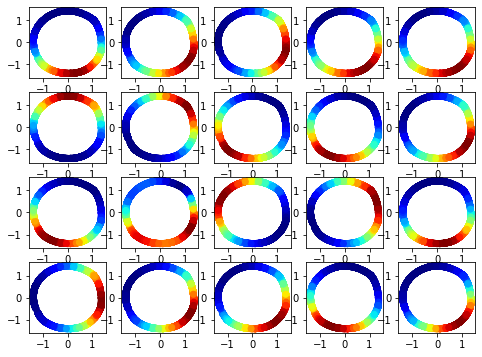

In [24]:
fig = plt.figure(figsize=(8,6))
for i in range(20):
    a1 = fig.add_subplot(4,5,i+1)
    a1.scatter(S1_embedding[:,0], S1_embedding[:,1], c=de_encoder2_train[:,i], cmap='jet')
plt.show()

Pre-train encoder output (regression from 20 hidden units to 3D data space). 


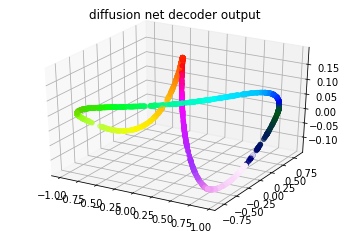

In [25]:
de_encoder3 = pretrain_regression(de_encoder2_train, S1_train, decoder_layer_sizes[1], decoder_layer_sizes[2], 
                               batch_size, reg_par=1e-10, n_epochs=N_EPOCHS) 
de_encoder3_train = de_encoder3.predict(de_encoder2_train)

fig, (a2)  = plt.subplots(1,1, subplot_kw={'projection':'3d'})
a2.scatter(de_encoder3_train[:,0], de_encoder3_train[:,1], de_encoder3_train[:,2], c=t_train, cmap='gist_ncar')
plt.axis('auto')
plt.title('diffusion net decoder output')
plt.show()

## Create model ############
Creating the full architrecture in TF and copying the pre-trained weights to initialize the DN encoder and decoder.

In [26]:
P  = tf.cast(tf.constant(P),tf.float32)
E1 = tf.cast(tf.constant(E1),tf.float32)
v1 = tf.cast(tf.constant(v1),tf.float32)

In [27]:
# init diffusion net encoder units from pretrained autoencoders
init = tf.constant(autoencoder1.get_weights()[0])
E_W1 = tf.Variable(init)
init = tf.constant(autoencoder1.get_weights()[1])
E_b1 = tf.Variable(init)
init = tf.constant(autoencoder2.get_weights()[0])
E_W2 = tf.Variable(init)
init = tf.constant(autoencoder2.get_weights()[1])
E_b2 = tf.Variable(init)
init = tf.constant(encoder3.layers[1].get_weights()[0])
E_W3 = tf.Variable(init)


In [28]:
# init diffusion net decoder units from pretrained autoencoders
init = tf.constant(de_autoencoder1.get_weights()[0])
D_W1 = tf.Variable(init)
init = tf.constant(de_autoencoder1.get_weights()[1])
D_b1 = tf.Variable(init)
init = tf.constant(de_autoencoder2.get_weights()[0])
D_W2 = tf.Variable(init)
init = tf.constant(de_autoencoder2.get_weights()[1])
D_b2 = tf.Variable(init)
init = tf.constant(de_encoder3.layers[1].get_weights()[0])
D_W3 = tf.Variable(init)


In [29]:
theta_E = [E_W1,E_W2, E_W3, E_b1, E_b2]
theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2]

In [30]:
def encoder(x):
    h1 = tf.nn.sigmoid(tf.matmul(x, E_W1) + E_b1)
    h2 = tf.nn.sigmoid(tf.matmul(h1, E_W2) + E_b2)
    h3 = tf.matmul(h2, E_W3)
    return h3

In [31]:
def decoder(z):
    h1 = tf.nn.sigmoid(tf.matmul(z, D_W1) + D_b1)
    h2 = tf.nn.sigmoid(tf.matmul(h1, D_W2) + D_b2)
    h3 = tf.matmul(h2, D_W3)
    return h3

In [32]:
X = tf.placeholder(tf.float32, shape=[None, input_size])
Z = encoder(X)

Y = tf.placeholder(tf.float32, shape=[None, embedding_size])
R = decoder(Y)

## Train deep encoder and decoder

Define learning params, encoder and decoder loss functions and optimization

In [33]:
# the parameters for training the network
learning_rate = 1e-2
n_iters = 4000

# params for loss function
reg_par = 1e-4
eta = 100

The cost function of the encoder including the eigenvector constraint:
$
J^e(\theta^e) = \frac{1}{m}\sum_{i=1}^m \Vert o^e(x_i) - \Psi(x_i) \Vert^2  + \mu \sum_{l=1}^{L-1}  \Vert \mathbf{W}^{(l)} \Vert_F^2 
 + \eta\frac{1}{m}\sum_{j=1}^{d} \Vert (\mathbf{P} - \lambda_j \mathbf{I}) (o^e_j)^T \Vert^2,
$

In [34]:
# set encoder loss
encoder_fidelity_loss = tf.reduce_mean(tf.square(Y-Z))
encoder_eigen_loss = 0
for i in range(embedding_size):
    mat = P - v1[i]*np.eye(n_train,dtype=np.float32)
    z_vec =  tf.slice(Z,[0,i],[-1,1])
    vec = tf.matmul(mat, z_vec)
    encoder_eigen_loss += tf.reduce_mean(tf.square(vec)) 
encoder_reg = tf.nn.l2_loss(E_W3) #+tf.nn.l2_loss(E_W1) + tf.nn.l2_loss(E_W2)  
encoder_loss = encoder_fidelity_loss + eta*encoder_eigen_loss + reg_par*encoder_reg

The decoder loss is

$J^d(\theta^d)  = \frac{1}{m}\sum_{i=1}^m  \Vert 
o^d(i) - x_i \Vert^2
 + \mu \sum_{l=1}^{L-1} \Vert \mathbf{W}^{\prime\,(l)} \Vert_F^2 ,$

In [35]:
# set decoder loss

decoder_reg = tf.nn.l2_loss(D_W3) #+tf.nn.l2_loss(D_W1) + tf.nn.l2_loss(D_W2)  
decoder_loss = tf.reduce_mean(tf.square(X-R)) + reg_par*decoder_reg

In [36]:
E_solver = (tf.train.AdamOptimizer(learning_rate=learning_rate)
            .minimize(encoder_loss, var_list=theta_E))
D_solver = (tf.train.AdamOptimizer(learning_rate=learning_rate)
            .minimize(decoder_loss, var_list=theta_D))

In [37]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

### train encoder

step 0, loss 9.14e-01


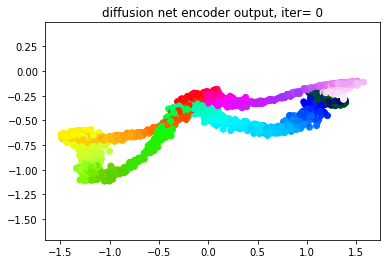

step 500, loss 4.43e-02


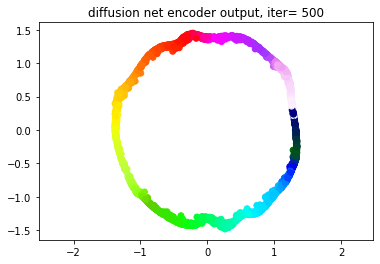

step 1000, loss 3.08e-02


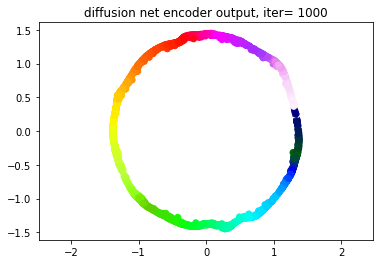

step 1500, loss 2.60e-02


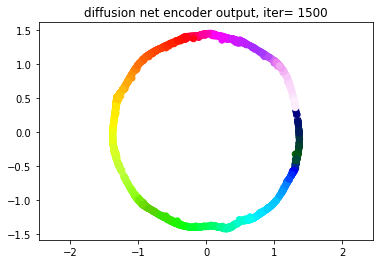

step 2000, loss 2.28e-02


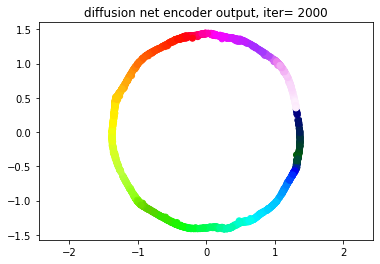

step 2500, loss 2.13e-02


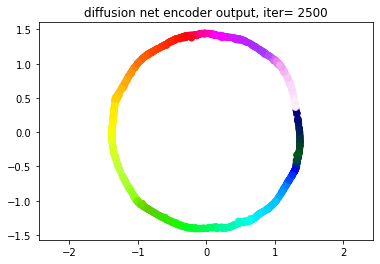

step 3000, loss 1.88e-02


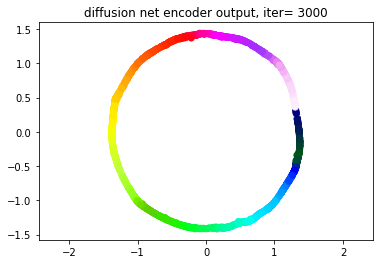

step 3500, loss 1.76e-02


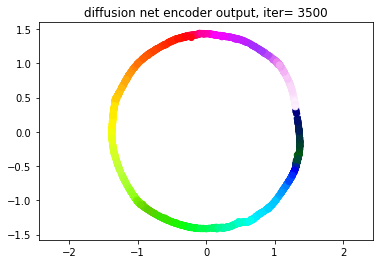

step 4000, loss 1.65e-02


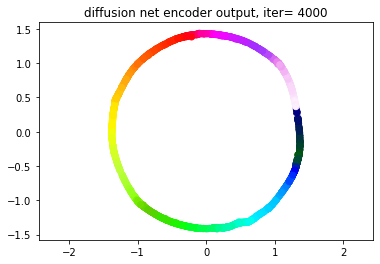

In [38]:
for i in range(n_iters+1):
    if i % 500 == 0: # plot intermediate outputs
        z = sess.run(Z, feed_dict={X: S1_train})
        loss = np.mean(np.sum(np.abs(S1_embedding - z)**2,axis=1)**(1./2))
        print('step %.d, loss %.2e' % (i, loss))
        fig, (a2)  = plt.subplots(1,1)
        a2.scatter(z[:,0], z[:,1], c=t_train, cmap='gist_ncar')
        plt.axis('equal')
        plt.title('diffusion net encoder output, iter= ' + str(i))
        plt.show()
        
    _ = sess.run(E_solver, feed_dict={X: S1_train, Y:S1_embedding})

### train decoder

step 0, loss 8.26e-01


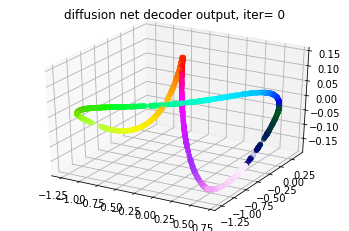

step 500, loss 1.06e-01


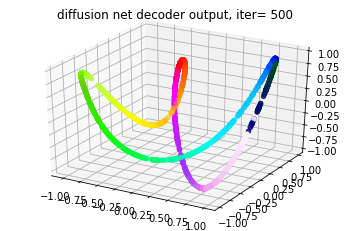

step 1000, loss 9.51e-02


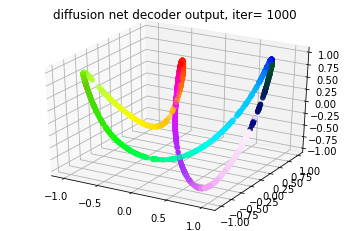

step 1500, loss 8.52e-02


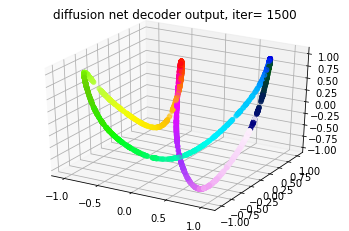

step 2000, loss 7.76e-02


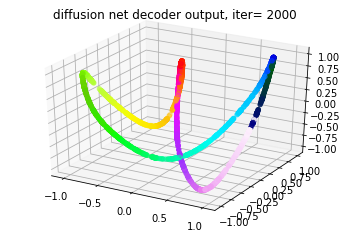

step 2500, loss 7.42e-02


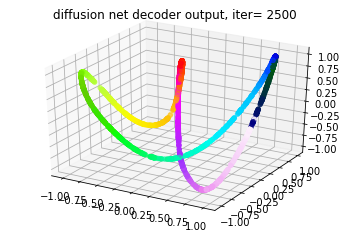

step 3000, loss 7.23e-02


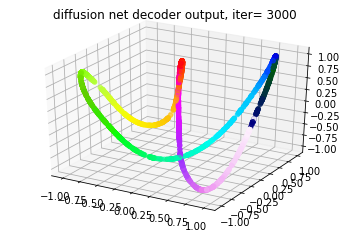

step 3500, loss 7.12e-02


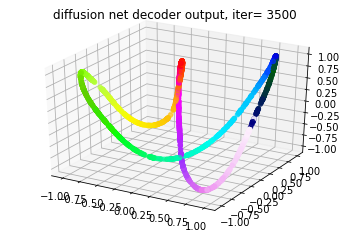

In [39]:
for i in range(n_iters):
    if i % 500 == 0: # plot intermediate outputs
        x = sess.run(R, feed_dict={Y:S1_embedding})
        loss = np.mean(np.sum(np.abs(S1_train - x)**2,axis=1)**(1./2))
        print('step %.d, loss %.2e' % (i, loss))
        fig, (a2) = plt.subplots(1,1, subplot_kw={'projection':'3d'})
        a2.scatter(x[:,0], x[:,1], x[:,2], c=t_train, cmap='gist_ncar')
        plt.axis('auto')
        plt.title('diffusion net decoder output, iter= ' + str(i))
        plt.show()
        
    _ = sess.run(D_solver, feed_dict={X: S1_train, Y:S1_embedding})

### output plots

In [48]:
# enocder and decoder outputs
z = sess.run(Z, feed_dict={X: S1_train})
r = sess.run(R, feed_dict={Y:S1_embedding})

In [49]:
loss = np.mean(np.sum(np.abs(S1_embedding - z)**2,axis=1)**(1./2))
print('Encoder loss %.2e' % (loss))
loss = np.mean(np.sum(np.abs(S1_train - r)**2,axis=1)**(1./2))
print('Decoder loss %.2e' % (loss))

Encoder loss 1.42e-02
Decoder loss 6.87e-02


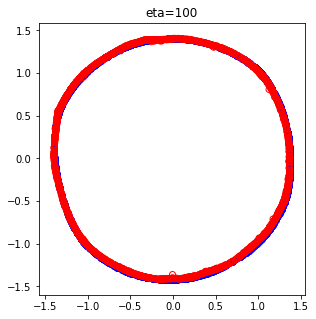

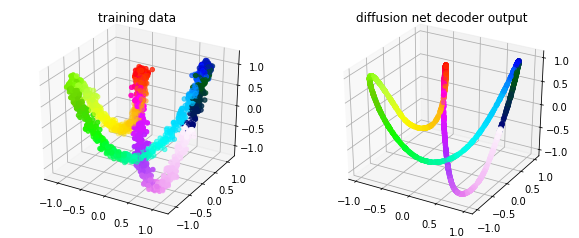

In [54]:
# Diffusion net outputs:
fig = plt.figure(figsize=(5,5))
a1 = fig.add_subplot(111)
a1.scatter(S1_embedding[:,0], S1_embedding[:,1],color='blue', zorder=1)
a1.scatter(z[:,0], z[:,1],facecolors='none', edgecolors='r', zorder=10)
a1.set_aspect('equal')
a1.set_title('eta=' +str(eta))

fig = plt.figure(figsize=(10,4))
a1 = fig.add_subplot(121,projection='3d')
a1.scatter(S1_train[:,0], S1_train[:,1], S1_train[:,2], c=t_train, cmap='gist_ncar')
plt.title('training data')
a2 = fig.add_subplot(122,projection='3d')
a2.scatter(r[:,0], r[:,1], r[:,2], c=t_train, cmap='gist_ncar')
plt.title('diffusion net decoder output')
plt.show()

### Stack autoencoder

The output of the encoder is fed into the decoder

In [51]:
z_test = sess.run(Z, feed_dict={X: S1_test})
r_test = sess.run(R, feed_dict={Y: z_test})

In [52]:
loss = np.mean(np.sum(np.abs(S1_test - r_test)**2,axis=1)**(1./2))
print('Full autoencoder loss %.2e' % (loss))

Full autoencoder loss 7.16e-02


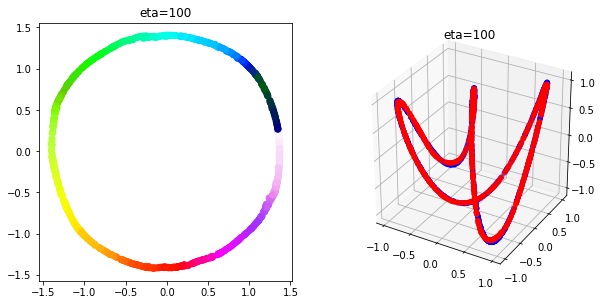

In [53]:
fig = plt.figure(figsize=(10,5))
a1 = fig.add_subplot(121)
a1.scatter(z_test[:,0], z_test[:,1],c=t_test, cmap='gist_ncar')
a1.set_aspect('equal')
a1.set_title('eta=' +str(eta))

a2 = fig.add_subplot(122,projection='3d')
a2.scatter(orig_data[n_train+1:,0], orig_data[n_train+1:,1], orig_data[n_train+1:,2], color='blue')
a2.scatter(r_test[:,0], r_test[:,1], r_test[:,2], color='red', zorder=10)
a2.set_title('eta=' +str(eta))
a2.set_aspect('equal')
plt.show()